In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import astropy.units as u
from astropy.stats import mad_std
import lightkurve as lk
from astropy.timeseries import LombScargle
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

import warnings
warnings.filterwarnings("ignore")


/opt/miniconda3/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/maryumsayeed/.lightkurve/cache. Please move all the files in the legacy directory /Users/maryumsayeed/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
rv_df  = pd.read_csv('comb_rvs.csv')
table4 = pd.read_csv('table4.csv')
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
table4[(table4.program==113) & (table4.RG_id==5)][['P50','e50','K50']]

,P50,e50,K50
6,19.677485,0.245723,1.13089


In [4]:
galah = Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits').to_pandas()

In [5]:
binary_list_113 = 1, 4, 5, 7, 9, 11, 16, 18, 19, 21, 23  
binary_list_112 = 5, 6, 7, 23 #13 removed because of dipper star

# Check the two planetary companions

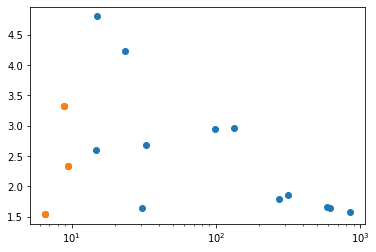

In [6]:
plt.scatter(table4.Mj50, table4.Li_val)
plt.xscale('log')

mask = (table4.Mj50<12)
plt.scatter(table4[mask].Mj50, table4[mask].Li_val)

table4[['sobject_id','ra_dr2','dec_dr2']].to_csv('all_table4.csv',index=False)

In [7]:
tess_ids = {
    1: {'GAIA': 4134444748741183488, 
     'TESS': 78326923,
     'GALAH': 170509005201208},
    2: {'GAIA': 2622883652325300992, 
     'TESS': 205846638,
     'GALAH': 140707003101315},}


In [11]:
crossmatch_tess_all = pd.read_csv('../files/crossmatch_tess_all_binaries.csv')#[['GAIA','TIC','WISEA','2MASS','ra_dr2','dec_dr2','RAJ2000','DEJ2000']]


In [79]:
merged = pd.merge(crossmatch_tess_all, table4, on='sobject_id')#[crossmatch_tess_all.program==113]
merged[merged.TIC==451423147][['TIC','sobject_id','P50','program','RG_id']]
merged[(merged.program==113) & (merged.RG_id==19)][['TIC','sobject_id','P50','program','RG_id']]
merged[merged.sobject_id==170416004301008][['TIC','sobject_id','P50','program','RG_id','Li_val']]

,TIC,sobject_id,P50,program,RG_id,Li_val
6,83864042,170416004301008,19.677485,113,5,4.8


In [64]:

# done: 397526519,369985256,405924915,361334013,451423147
from utils import PLOT_PARAMS
PLOT_PARAMS()
def make_paper_plot(tic):
    sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS',author='QLP')
    lcs = sr.download_all()
    if len(lcs) == 4:
        fig = plt.figure(figsize=(5,10))
    elif len(lcs) == 2:
        fig = plt.figure(figsize=(5,5))
    elif len(lcs) == 3:
        fig = plt.figure(figsize=(6,6))
        
    
    for i,lc in enumerate(lcs):
        ax = plt.subplot(len(lcs),1,i+1)
        lc = lc.remove_outliers()
        time, flux = lc.time.value, lc.flux.value
        pg = lc.normalize(unit='ppm').to_periodogram(freq_unit=u.microHertz)
        ax.plot(time, flux, lw=0.5, color='k')
#         lc.remove_outliers().plot(ax=ax)
    
    fig.text(0.5, 0.0, 'Time [days]', ha='center')
    fig.text(-0.03, 0.5, 'Normalized Flux', va='center', rotation='vertical')
    
    plt.tight_layout()
#     plt.savefig('../plots/tess_prot_%s.png'%tic,bbox_inches='tight',dpi=200)
    print(sr.author)
# make_paper_plot()


In [ ]:
sr1 = lk.search_lightcurve('TIC 78326923', mission='TESS')

In [8]:
crossmatch_tess_planets = pd.read_csv('../files/crossmatch_tess.csv')

In [9]:
crossmatch_tess_planets[['GAIA','TIC','WISEA','2MASS','ra_dr2','dec_dr2','RAJ2000','DEJ2000']]

,GAIA,TIC,WISEA,2MASS,ra_dr2,dec_dr2,RAJ2000,DEJ2000
0,4134444748741183488,78326923,J171459.26-181507.6,17145926-1815075,258.746905,-18.252141,258.746931,-18.252119
1,2622883652325300992,205846638,J222903.80-062524.5,22290380-0625244,337.265875,-6.423480,337.265848,-6.423464


In [10]:
ss

NameError: name 'ss' is not defined

In [ ]:

sr1 = lk.search_lightcurve('TIC 78326923', mission='TESS')
lc1 = sr1.download()
lc1.plot()
lc1 = lc1.remove_nans().remove_outliers() 
lc1.plot()

In [ ]:
sr2 = lk.search_lightcurve('TIC 205846638', mission='TESS')
lc2 = sr2.download_all()
lc2[0].plot()
lc2a = lc2[0].remove_nans().remove_outliers()
lc2a.plot()

lc2[1].plot()
lc2b = lc2[1].remove_nans().remove_outliers()
lc2b.plot()

In [ ]:
print('cadence in days:',np.median(np.diff(lc1['time'].value)))
print('cadence in mins:',np.median(np.diff(lc1['time'].value))*86400./60)
print('cadence in seconds:',np.median(np.diff(lc1['time'].value))*86400.)

In [ ]:
sr2
print('cadence in days:',np.median(np.diff(lc2[0]['time'].value)))
print('cadence in mins:',np.median(np.diff(lc2[0]['time'].value))*86400./60)
print('cadence in seconds:',np.median(np.diff(lc2[0]['time'].value))*86400.)
print('\n')
print('cadence in days:',np.median(np.diff(lc2[1]['time'].value)))
print('cadence in mins:',np.median(np.diff(lc2[1]['time'].value))*86400./60)
print('cadence in seconds:',np.median(np.diff(lc2[1]['time'].value))*86400.)

In [ ]:
pg1 = lc1.normalize(unit='ppm').to_periodogram(freq_unit=u.microHertz)
pg1.plot()

In [ ]:

pg2 = lc2a.normalize(unit='ppm').to_periodogram(freq_unit=u.microHertz)
pg2.plot()
pg2 = lc2b.normalize(unit='ppm').to_periodogram(freq_unit=u.microHertz)
pg2.plot()

# Download lightcurves from TESS for all targets:

In [ ]:
si = crossmatch_tess_all[crossmatch_tess_all.TIC==167669457]['sobject_id'].values[0]
print(si)
print(table4[table4.sobject_id==si].Mj50.values[0])
print(table4[table4.sobject_id==si].P50.values[0])
print(table4[table4.sobject_id==si].radius_bstep.values[0])

In [ ]:
def remove_prot(lc, ax=False, width=1.):
    time = lc.time.value
    cadence_days = np.median(np.diff(time))#days
    cadence_mins = cadence_days*86400./60.
    cadence_secs = cadence_days*86400.
#     print('Cadence in Days: %.1f \t Mins: %.2f \t Secs: %.3f'%(cadence_days,cadence_mins,cadence_secs))
    boxsize=int(width/cadence_days)-1 #width in days
    lc_flat=lc.flatten(window_length=boxsize)
    if ax:
        lc_flat.plot(ax=ax)
    return lc_flat

def remove_outliers(lc_flat, ax=False, N=5.):
    # Remove data points > N*sigma:
    std =mad_std(lc_flat.flux,ignore_nan=True)
    med =np.nanmedian(lc_flat.flux)
    idx =np.where(abs(lc_flat.flux-med)<=(N*std))[0]
    time=lc_flat.time[idx].value
    flux=lc_flat.flux[idx].value
    lc = lk.LightCurve(time, flux)
    if ax:
        lc.plot(ax=ax)
    return lc
   
def calc_periodogram(lc, ax):
    pg_flat=lc.to_periodogram(method='lombscargle',normalization='psd')#,oversample_factor=1)
    pg_flat.plot(ax=ax,scale='log')

In [ ]:
'TIC %s'%397526519

In [ ]:

# freq, amp = LombScargle(time, flux).autopower(method = 'fast',samples_per_peak=1, maximum_frequency=nyq_cd)
# freq = 1e6*freq/(86400.)  # convert frequency to muHz
# res  = freq[1]-freq[0]
# psd  = 2.*amp*np.var(flux*1e6)/(np.sum(amp)*res)

# cadence = np.nanmedian(np.diff(time))       # cadence in days (=60 s)
# cadence = int(cadence*60.*60.*24.)   # cadence in secs
# nyq     = 1./(2.*cadence)       # Nyq. frequency in Hz
# nyq_cd  = nyq*86400.            # Nyq. frequency in cycles/day
# #print('Cadence [s]',round(cadence,2),'Nyquist [Hz]',round(nyq,9),'Nyquist [c/d]',round(nyq_cd,2))


In [ ]:
def remove_gaps(all_time, all_flux):
    #ax1.plot(all_time, all_flux,lw=0.1)
    
    df = pd.DataFrame({'time': all_time, 'flux': all_flux})
    df['delta']  = df['time'].diff()              # diff from previous time
    df['gap']    = df['delta']>=2.                # gap = diff > 2 days
    df['group']  = df['gap'].cumsum()             # make groups
    
    groups = df.groupby('group')
    
    min_time = np.zeros(len(groups))
    max_time = np.zeros(len(groups))
    
    for i, g in groups:
        min_time[i]=min(g['time'])
        max_time[i]=max(g['time'])
    
    new_times = {}
    new_flux  = {}
    total_dt = 0
    for i, g in groups:
        if i > 0:
            dt  = min_time[i] - max_time[i-1]
            total_dt+=dt
            new_times[i] = g['time']-(total_dt)
            
        else:
            new_times[i] = g['time']
        new_flux[i] = g['flux']

    all_time, all_flux = [], []
    for i in range(len(groups)):
        all_time.append(list(new_times[i]))
        all_flux.append(list(new_flux[i]))

    from itertools import chain
    all_time = list(chain.from_iterable(all_time))
    all_flux = list(chain.from_iterable(all_flux))

    all_time, all_flux = np.array(all_time), np.array(all_flux)
    return all_time, all_flux
    
    

In [ ]:
# sr = lk.search_lightcurve('TIC %s'%38023437, mission='TESS')
# lcs = sr.download_all()
# ax1=plt.subplot(211)
# ax2=plt.subplot(212)
# for lc in lcs: 
#     t1,f1 = lc.time.value, lc.flux.value
#     t2,f2 = lc.time.value, f1*1e-6+1
#     ax1.plot(t1,f1,lw=1)
#     ax2.plot(t2,f2,lw=1)
# plt.tight_layout()
# plt.show()
    
# # lc.meta

In [ ]:

# data = np.random.random(100)
# bins = np.linspace(0, 1, 10)
# dig = np.digitize(data, bins)
# bin_means = [data[dig == i].mean() for i in range(1, len(bins))]

# plt.plot(data)
# plt.plot(bin_means)


In [ ]:
lk.search_lightcurve('TIC %s'%397526519, mission='TESS')

sr = lk.search_lightcurve('TIC %s'%397526519, mission='TESS') 

# lcs = sr.download_all()
new_sr = []
d = {}
for i in sr:
    print(i.author,i.mission)# (i.mission).split(' '))
    if i.mission[0] not in d.keys():
        d[i.mission[0]]=[i.author[0]]
    else:
        d[i.mission[0]].append(i.author[0])
        


In [ ]:
d
ts_65 = lk.search_lightcurve('TIC %s'%397526519, mission='TESS',author='TESS-SPOC',sector=65) 
ts_64 = lk.search_lightcurve('TIC %s'%397526519, mission='TESS',sector=64) 

In [ ]:
ts_64
lcs = []
for k,v in d.items():
    sector = k.split(' ')[-1]
    if len(v) == 1:
        sr = lk.search_lightcurve('TIC %s'%397526519, mission='TESS',author=v[0],sector=sector) 
        lc = sr.download()
    else:
        if 'TESS-SPOC' in v:
            print(v)
            sr = lk.search_lightcurve('TIC %s'%397526519, mission='TESS',author='TESS-SPOC',sector=sector) 
            lc = sr.download()
            print(v)
        elif 'QLP' in v:
            sr = lk.search_lightcurve('TIC %s'%397526519, mission='TESS',author='QLP',sector=sector)
            lc = sr.download()
    lcs.append(lc)


In [ ]:
# lc.exptime
(lc.time[1]-lc.time[0])*86400

In [ ]:
# for lc in lcs:

for lc in lk.LightCurveCollection(lcs) :
    
    if lc.author == 'TESS-SPOC':
        print('ts',(lc.time[1]-lc.time[0])*86400)
        lc.remove_nans().remove_outliers().plot(normalize=True)
    else:
        print((lc.time[1]-lc.time[0])*86400)

In [ ]:
star=165063707
sr = lk.search_lightcurve('TIC %s'%star, mission='TESS') 
sr


In [ ]:
lk.search_lightcurve('TIC %s'%star, mission='TESS', author='QLP').download_all().plot()


In [ ]:
lk.search_lightcurve('TIC %s'%star, mission='TESS', author='TESS-SPOC').download_all().plot()


In [ ]:
for i,star in enumerate([34732287, 38023437, 129040309,#397526519,
             306791669, 167669457, 83864042, 369985256, 205846638, 
             78326923, 405924915, 451423147, 361334013, 412764815, 165063707]):
    sr = lk.search_lightcurve('TIC %s'%star, mission='TESS')
    if i != 0: continue
    print(sr.mission)

In [ ]:
sectors = {129040309: [0,1],306791669:[0,1]}

In [ ]:
plt.rcParams['figure.facecolor'] = 'white'
def do_seismology(tic,priority=False,sectors=False):
    if priority:
        sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS',author=priority)
        lcs = sr.download_all()
        if sectors:
            lcs=lcs[sectors]
    else:
        # 1st: save all sectors and authors for each:
        sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS')
        
        d = {}
        for i in sr:
            if i.mission[0] not in d.keys():
                d[i.mission[0]]=[i.author[0]]
            else:
                d[i.mission[0]].append(i.author[0])

        # 2nd: prioritize TESS-SPOC first, then QLP:
        lcs = []
        for k,v in d.items():
            sector = k.split(' ')[-1]
            if len(v) == 1:
                sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS',author=v[0],sector=sector) 
                lc = sr.download()
            else:
                if 'TESS-SPOC' in v:
                    sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS',author='TESS-SPOC',sector=sector) 
                    lc = sr.download()
                elif 'QLP' in v:
                    sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS',author='QLP',sector=sector)
                    lc = sr.download()
            lcs.append(lc)

        lcs = lk.LightCurveCollection(lcs) 
        print(len(lcs))
    
    rows, cols = int(len(sr) / 2), 2
    figsize=(12,4)
    all_time, all_flux = [],[]
    
    time_before_bin, flux_before_bin = [],[]
    
    stds = np.zeros(len(lcs))
    for ii, lc in enumerate(lcs):
        fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(8,12))
        lc.plot(ax=ax1,label='unbinned')
        #time, flux = lc.time.value, lc.flux.value
#         if max(flux) > 2.:
#             print(ii, 'here')
#             flux = flux*1e-6+1
        
        # remove rotation
        lc_flat = remove_prot(lc,ax2)
        
        # remove outliers
        lc_flat = remove_outliers(lc_flat,ax3)        
        
        time_before_bin.append(lc_flat.time.value)
        flux_before_bin.append(lc_flat.flux.value)
        
        # binning
        time = lc_flat.time.value
        flux = lc_flat.flux.value
        
        exp_cadence_days = 30./(60.*24.) # 30 min cadence
        obs_cadence_days = np.median(np.diff(time))
        
        if abs(round(obs_cadence_days*86400)-1800)<=1.:
            print('here',len(lc_flat))
            binned_lc = lc_flat*1
        else:
            Nth  = round(exp_cadence_days/obs_cadence_days)
            binned_time, binned_flux = time.copy(), flux.copy()
            binned_time, binned_flux = binned_time[1::Nth], binned_flux[1::Nth]
            binned_lc     = lk.LightCurve(time=binned_time, flux=binned_flux)

        # save binned lightcurve
        all_time.append(binned_lc.time.value)
        all_flux.append(binned_lc.flux.value)
        stds[ii] = np.nanstd(binned_lc.flux.value)
        
        # plot binned lightcurve
        binned_lc.plot(ax=ax3,label='binned')  
        ax3.legend()
        plt.tight_layout()
        plt.close()
        
        
    
#     plt.figure(figsize=(8,4))
#     for i in range(len(all_time)):
#         plt.plot(all_time[i],all_flux[i])
#     plt.show()
    print('std',stds)
#     mask = np.where(stds<=1.25*(np.median(stds)))[0]
    
#     t, f = [], []
#     for i in range(len(all_time)):
#         if i in mask:
#             t.append(all_time[i])
#             f.append(all_flux[i])
    
#     all_time, all_flux = t*1, f*1
#     plt.figure(figsize=(8,4))
#     for i in range(len(all_time)):
#         plt.plot(all_time[i],all_flux[i],label=i,alpha=0.5)
#     plt.legend()
#     plt.show()
    
    # removing gaps routine (binned data)
    all_time = np.array([i for sublist in all_time for i in sublist])
    all_flux = np.array([i for sublist in all_flux for i in sublist])
    
    sorted_i = np.argsort(all_time)
    all_time = all_time[sorted_i]
    all_flux = all_flux[sorted_i]
    
    new_time, new_flux = remove_gaps(all_time, all_flux)
    
    # removing gaps routine (not-binned data)
    time_before_bin =  np.array([i for sublist in time_before_bin for i in sublist])
    flux_before_bin =  np.array([i for sublist in flux_before_bin for i in sublist])
    sorted_i = np.argsort(time_before_bin)
    time_before_bin, flux_before_bin = time_before_bin[sorted_i], flux_before_bin[sorted_i]
    time_before_bin, flux_before_bin = remove_gaps(time_before_bin, flux_before_bin)
#     all_time_og, all_flux_og = np.copy(all_time),np.copy(all_flux),
        
    

#     plt.figure(figsize=(8,4))
#     plt.plot(new_time, new_flux)
#     plt.legend()
#     plt.show()
    
    cadence_30min = int(30*60.)     # 30 mins cadence in secs
    nyq     = 1./(2.*cadence_30min) # Nyq. frequency in Hz
    nyq_cd  = nyq*86400.            # Nyq. frequency in cycles/day

    def manual_periodogram(time, flux):
        freq, amp = LombScargle(time, flux).autopower(method = 'fast', maximum_frequency=nyq_cd)#,samples_per_peak=1)
        freq = 1e6*freq/(86400.)  # convert frequency to muHz
        res  = freq[1]-freq[0]
        psd  = 2.*amp*np.var(flux*1e6)/(np.sum(amp)*res)
        return freq, psd

    fig, (ax1a,ax1b,ax2,ax3) = plt.subplots(4,1,figsize=(8,10))
    
    ax1a.plot(all_time, all_flux, lw=1,label='data for all sectors\n(outliers/period removed)')
    ax1a.set_title('gaps not removed',fontsize=10)
    
    ax1b.set_title('gaps removed',fontsize=10)
    ax1b.plot(time_before_bin, flux_before_bin, lw=1,label='before binning', alpha=0.5)
    ax1b.plot(new_time, new_flux, lw=1,label='after binning', alpha=0.5)
    
#     ax1b.plot(new_time, new_flux, lw=1,label='removing outliers & prot again')
    
    lc1 = lk.LightCurve(time=all_time, flux=all_flux)
    lc2 = lk.LightCurve(time=new_time, flux=new_flux)
    
    lc1 = remove_outliers(lc1,N=3)
    lc2 = remove_outliers(lc2,N=3)
    all_time , all_flux = lc1.time.value, lc1.flux.value
    new_time , new_flux = lc2.time.value, lc2.flux.value

    #ax1b.plot(new_time, new_flux, label='manual removal')
    
    freq, psd         = manual_periodogram(all_time, all_flux)
    new_freq, new_psd = manual_periodogram(new_time, new_flux) 

    fres_cd     = 30./(24.*60.)  #to check if it's smoothed by 2muHz: print(freq[0],freq[0+n]) difference should be 2
    smooth_freq = 0.5
    
    fres_mhz    = fres_cd/0.0864
    n  = int(smooth_freq/fres_mhz)
    gauss_kernel = Gaussian1DKernel(n)
    new_pssm   = convolve(new_psd, gauss_kernel)

    ax2.loglog(freq, psd,lw=1,label='gaps not removed')
    ax2.loglog(new_freq, new_psd,lw=1,label='gaps removed')
    
    #ax2.loglog(new_freq, new_pssm,lw=1,c='k',label='smoothed')
    ax2.set_xlim(1,280)
    
    ax3.plot(freq, psd,lw=1,label='gaps not removed')
    ax3.plot(new_freq, new_psd,lw=1,label='gaps removed')
    ax3.set_xlim(1,100)
    
    for ax in [ax1a,ax1b,ax2,ax3]: ax.legend()
    
    mask = (new_freq>20.)
    new_freq, new_psd = new_freq[mask], new_psd[mask]
    lc_data = np.array([new_time, new_flux]).T
    ps_data = np.array([new_freq, new_psd]).T

    np.savetxt('%s_LC.txt'%tic, lc_data)
    np.savetxt('%s_PS.txt'%tic, ps_data)
#     ax1b.set_xlim(1625,1652)
#     ax1b.set_ylim(0.998,1.002)
    plt.tight_layout()
    plt.savefig('%s_tess_5.png'%tic,bbox_inches='tight',dpi=200)
#     plt.close()
    
# do_seismology(397526519,priority='TESS-SPOC')

# messaged dan about this 'issue':
# do_seismology(34732287,priority='QLP')  # remove last sector?
# do_seismology(38023437,priority='QLP')  # remove last sector?
# do_seismology(167669457,priority='QLP') # same problem as message to Dan
# do_seismology(361334013,priority='QLP') # same problem as message to Dan

# do_seismology(405924915,priority='QLP')
# do_seismology(451423147,priority='TESS-SPOC')

do_seismology(412764815,priority='QLP')
do_seismology(165063707,priority='QLP')

# do_seismology(129040309,priority='QLP',sectors=sectors[129040309]) 
# do_seismology(306791669,priority='QLP',sectors=sectors[306791669]) 


# 427449567 - removed YSO
# for i,star in enumerate([34732287, 38023437, 129040309,#397526519,
#              306791669, 167669457, 83864042, 369985256, 205846638, 
#              78326923, 405924915, 451423147, 361334013, 412764815, 165063707]):
#     print(i,star)
#     try:
#         do_seismology(star)
#     except Exception as e:
#         print(e)

In [ ]:
# pysyd run --star 129040309 --numax 50  --lp 47 --up 58  --sp 0.02 --lb 20
# pysyd run --star 397526519 --numax 50 --lp 42 --up 60 --sp 0.05 --lb 30
# pysyd run --star 306791669 --numax 50  --lp 40 --up 60 --sp 0.05 --lb 20


In [ ]:


#     if tic == 34732287 : 
#         m1 = (all_time >= 1488.)
#         m2 = (new_time >= 1488.)
# #     elif tic == 397526519: 
# #         m1 = (all_time <= 1620.),
# #         m2 = (new_time <= 1620.),
#     elif tic == 38023437: 
#         m1 = (all_time <= 1488.),
#         m2 = (new_time <= 1488.),
#     elif tic == 129040309 : 
#         m1 = (all_time<=1682),
#         m2 = (new_time<=1682),
#     elif tic == 306791669 : 
#         m1 = (all_time>=1642),
#         m2 = (new_time>=1642),
#     elif tic == 167669457 : 
#         m1 = ((all_time>=1600)  & (all_time<=1610)) | (all_time>=1615),
#         m2 = ((new_time>=1600)  & (new_time<=1610)) | (new_time>=1615),
#     elif tic == 83864042: 
#         m1 = (all_time<=1622),
#         m2 = (new_time<=1622),
#     elif tic == 78326923: 
#         m1 = (all_time<=3782) | (all_time>=3786 & (all_time<=3797)),
#         m2 = (new_time<=3782) | (new_time>=3786 & (new_time<=3797)),
#     elif tic == 405924915: 
#         m1 = (all_time>=1657),
#         m2 = (new_time>=1657),
#     elif tic == 451423147: 
#         m1 = (all_time<=2390.),
#         m2 = (new_time<=2390.),
#     elif tic == 361334013: 
#         m1 = (all_time>=1652) & (all_time<=1680)
#         m2 = (new_time>=1652) & (new_time<=1680)
#     else:
#         m1 = (all_time > 0)
#         m2 = (new_time > 0)
        
#     new_time, new_flux = new_time[m2], new_flux[m2]

In [ ]:
ss

In [ ]:
def make_ind_plots(tics): 
    for i,tic in enumerate(np.sort(tics)):
        try:
            sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS')
            print(len(sr))
            if len(sr) == 1:
                lc = sr.download_all()
                plt.figure(figsize=(8,4))
                ax = plt.subplot(1,1,1)
                lc.plot(ax=ax,normalize=True)
                plt.tight_layout()
                plt.savefig('../plots/tess_lcs/%s.png'%tic,bbox_inches='tight',dpi=200)
                plt.show()
                rows, cols = 1, 1
            elif len(sr)%2 == 0:#even
                rows, cols = int(len(sr) / 2), 2
                
                lcs = sr.download_all()
                if len(sr) ==2:
                    figsize=(12,4)
                elif len(sr) ==4:
                    figsize=(12,8)
                elif len(sr) > 4:
                    figsize=(12,14)
                
                fig = plt.figure(figsize=figsize)
                for ii, lc in enumerate(lcs):
                    ax=plt.subplot(rows,cols,ii+1)
                    lc.plot(ax=ax,normalize=True)
                plt.tight_layout()
                plt.savefig('../plots/tess_lcs/%s.png'%tic,bbox_inches='tight',dpi=200)
                plt.show()
                
            elif len(sr)%2 == 1:#odd
                rows, cols = int((len(sr)+1)/2), 2
                
                lcs = sr.download_all()
                if len(sr) == 3:
                    figsize=(12,8)
                elif len(sr) > 4:
                    figsize=(12,14)
                
                fig = plt.figure(figsize=figsize)
                for ii, lc in enumerate(lcs):
                    ax=plt.subplot(rows,cols,ii+1)
                    lc.plot(ax=ax,normalize=True)
                plt.tight_layout()
                plt.savefig('../plots/tess_lcs/%s.png'%tic,bbox_inches='tight',dpi=200)
                plt.show()
        except Exception as e:
            print(e)
make_ind_plots(crossmatch_tess_all.TIC)

In [ ]:
print(crossmatch_tess_all.TIC.tolist())

In [ ]:
def download_data(tic=False):
    if tic:
        try:
            sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS')
            lc = sr.download_all()
            lc.plot()

    #         lc[2].plot(ax=ax,normalize=True)
    #         #ax.set_xlim(2339, 2341)
    #         plt.show()
            print(len(sr))
            for l in lc:
                l = l.remove_nans()#.remove_outliers() 
                l.plot()
        except Exception as e:
            print(e)
            
    else:
        for i, row in all_tics.iterrows():
            tic = row['TIC']
            print(i,tic)
            try:
                sr1 = lk.search_lightcurve('TIC %s'%tic, mission='TESS')
                print(len(sr1))
                lc1 = sr1.download_all()
                lc1.plot()
            except Exception as e:
                print(e)

    #         lc1.plot()
    #         



In [ ]:
download_data()

In [ ]:
def dd2(tic):
    sr = lk.search_lightcurve('TIC %s'%tic, mission='TESS')
    lc = sr.download_all()
    #lc[1].plot()
    plt.figure(dpi=200)
    ax=plt.subplot(111)
    lc[1].plot(ax=ax,normalize=True)
    ax.set_xlim(2335,2340)
    ax.set_ylim(0.95,1.05)
    ax.axhline(1.02)
    ax.axhline(1.0)
dd2(167669457)